# Calculating the North Atlantic Oscillation Index

The North Atlantic Oscillation index (NAOi) is a pressure difference oscillation in the North Atlantic between two regions separated primarily by latitude. Various methods have been employed to calculate the NAOi, and one way by which we can categorise these methods is based on whether the data is an observational dataset (usually present in a non-gridded format only at specific locations) or a gridded dataset (usually model output).

The most common way to calculate the NAOi in models is using an Empirial Orthogonal Function (EOF) analysis. We present an EOF analysis for the North Atlantic region below. We use the `historical` setup of the 1 degree-ACCESS-CM2 model. Outputs for this model are available at `/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2`.

In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from numpy import unravel_index

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)

import datetime, time, os, sys
from glob import glob
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.collections import LineCollection
from scipy.signal import argrelextrema
import pylab as pl
import matplotlib as mpl
import cartopy.feature as cft

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
#matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0
import xesmf as xe

from eofs.xarray import Eof
from eofs.examples import example_data_path

from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats
import math

In [2]:
from dask.distributed import Client
client = Client()
client.amm.start()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43767,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:43411,Total threads: 4
Dashboard: /proxy/46533/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:43019,


In [3]:
## 1. Run to analyse

dir = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/'
run = 'r1i1p1f1'
scenario = 'historical'

## 2. Start and end times
start_time, end_time = '1950-12-01', '2014-11-30'

## 3. North Atlantic ocean coordinates
x_min, x_max = -90, 10
y_min, y_max = 10, 75

## 4. Constants
m3_to_Sv = 1e6
ρ0 = 1036
neofs = 3
neigs = 3
npcs = 3
r0 = 6.371 * 10**6

## 5. Plotting land boundaries
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='papayawhip', linewidth=0.5)

## Regridding functions

In [4]:
model_out = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc')

def regridder(da_in, label):
    if(label == 'ocean'):
        return regridder_ocean_to_ocean(da_in)
    elif(label == 'atmos'):
        return regridder_atmos_to_ocean(da_in)
    else:
        print('Error: Select between ocean and atmos grids.')
        
def regridder_atmos_to_ocean(da_in):
    grid_in = {'lon': da_in.lon.values, 'lat': da_in.lat.values}
    grid_out = {'lon': model_out.xt_ocean.values, 'lat': model_out.yt_ocean.values}
    
    ## Keep periodic = True, otherwise you get erroneous values at 0 longitude. 
    ## See https://github.com/JiaweiZhuang/xESMF/issues/101 for more details.
    RG = xe.Regridder(grid_in, grid_out, 'bilinear', periodic = True)
    regridded_da = RG(da_in)
    
    regridded_da = regridded_da.rename({"lon": "xt_ocean", "lat": "yt_ocean"})
    regridded_da = regridded_da.assign_coords({"geolon_t": model_out.geolon_t, "geolat_t": model_out.geolat_t})

    return regridded_da

def regridder_ocean_to_ocean(da_in):
    grid_in = {'lon': da_in.longitude.values, 'lat': da_in.latitude.values}
    grid_out = {'lon': model_out.geolon_t.values, 'lat': model_out.geolat_t.values}
    
    ## Keep periodic = True, otherwise you get erroneous values at 0 longitude. 
    ## See https://github.com/JiaweiZhuang/xESMF/issues/101 for more details.
    RG = xe.Regridder(grid_in, grid_out, 'bilinear', periodic = True)
    regridded_da = RG(da_in)

    regridded_da = regridded_da.rename({"y": "yt_ocean", "x": "xt_ocean"})
    regridded_da = regridded_da.assign_coords({"xt_ocean": model_out.xt_ocean, "yt_ocean": model_out.yt_ocean})
    regridded_da = regridded_da.rename({"lon": "geolon_t", "lat": "geolat_t"})

    return regridded_da

0.3.0


## Using 500 hPa geopotential height to calculate NAO index

The standard NAOi is computed by observing the spatial and temporal variability in the pressure at 500 hPa geopotential height. Since the NAOi is strongest in winter months, we limit our analysis to December, January, and Februrary months.

In [5]:
# Take the 500 hPa geopotential height and selecting Dec, Jan, Feb data only
hgt500 = xr.open_dataset(dir + '/' + scenario + '/' + run + '/' + '/Amon/zg/gn/latest/zg_Amon_ACCESS-CM2_' + scenario + '_' + run + '_gn_195001-201412.nc').zg.sel(plev = 50000, method = 'nearest')
hgt500 = hgt500.sel(time = slice(start_time, end_time))

# Selecting Dec, Jan, Feb months
hgt500 = hgt500.where(hgt500.time.dt.month.isin([12, 1, 2]), drop = True)

# Regridding to a proper grid
hgt500 = regridder(hgt500, 'atmos')
hgt500

# Selecting North Atlantic region
hgt500_NA = hgt500.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))

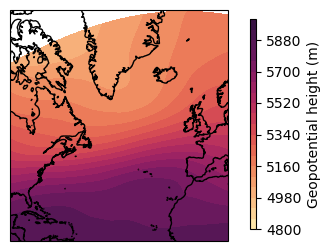

In [6]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (3, 3), subplot_kw = {'projection': projection})

p1 = axes.contourf(hgt500_NA.geolon_t, hgt500_NA.geolat_t, hgt500_NA[0], levels = np.linspace(4800, 6000, 21), 
                           cmap = cm.cm.matter, transform = ccrs.PlateCarree())

cax = plt.axes([0.95, 0.15, 0.02, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Geopotential height (m)', fontsize = 10)

axes.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
axes.coastlines(resolution = '50m')

In [7]:
# Compute anomalies
hgt500_mean = hgt500_NA.mean('time')
hgt500_amly = hgt500_NA - hgt500_mean

In [8]:
# Solve for EOF.
coslat = np.cos(np.deg2rad(hgt500_NA.yt_ocean.values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver_DJF = Eof(hgt500_amly.drop(['geolon_t', 'geolat_t']), weights = wgts)
eof_DJF = solver_DJF.eofsAsCovariance(neofs = neofs)

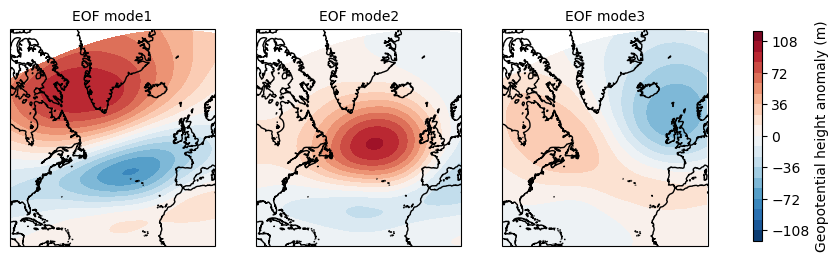

In [9]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(hgt500_NA.geolon_t, hgt500_NA.geolat_t, eof_DJF[0], levels = np.linspace(-120, 120, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree())

p2 = axes[1].contourf(hgt500_NA.geolon_t, hgt500_NA.geolat_t, eof_DJF[1], levels = np.linspace(-120, 120, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree())

p3 = axes[2].contourf(hgt500_NA.geolon_t, hgt500_NA.geolat_t, eof_DJF[2], levels = np.linspace(-120, 120, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree())

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Geopotential height anomaly (m)', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title('EOF mode' + str(i+1), fontsize = 10)

In [10]:
# Fraction
print('Percentage of EOF explained by first ' + str(neigs) + ' modes:' + str(100 * np.round(solver_DJF.varianceFraction(neigs = neigs).values, 4)))

Percentage of EOF explained by first 3 modes:[39.86 20.26 10.58]


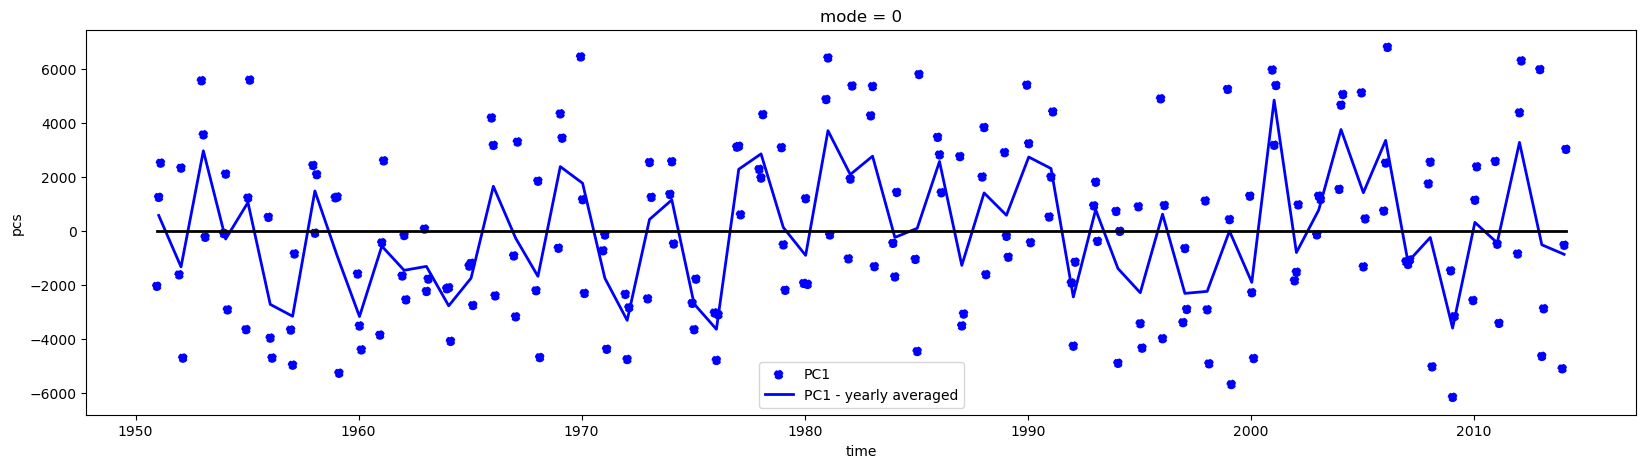

In [11]:
plt.figure(figsize = (20, 5))
#npcs = number of PCs, 
#pscaling = 0 -> unscaled variance scaling of PCs
#         = 1 -> scaled to unit variance
#         = 2 -> PC multiplied by the square root of their eigenvalue

pcs_hgt_DJF = solver_DJF.pcs(npcs = npcs, pcscaling = 0)
pcs_hgt_DJF.sel(mode = 0).plot.scatter(color = 'blue', label = 'PC1', ls = '--')
pcs_hgt_DJF.sel(mode = 0).coarsen(time = 3).mean().plot(color = 'blue', label = 'PC1 - yearly averaged')
plt.plot(pcs_hgt_DJF.sel(mode = 1).time, np.zeros(192), color = 'black')
plt.legend()

## EOF for wind stress

Changes in pressure are directly correlated with anomalies in wind stress. We check this correlation below.

In [12]:
tauu = xr.open_dataset(dir + '/' + scenario + '/' + run + '/' + 'Amon/tauu/gn/latest/tauu_Amon_ACCESS-CM2_' + scenario + '_' + run + '_gn_185001-201412.nc').tauu
tauu = tauu.sel(time = slice(start_time, end_time))

tauu = tauu.where(tauu.time.dt.month.isin([12, 1, 2]), drop = True)
tauu = regridder(tauu, 'atmos')
tauu_NA = tauu.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))

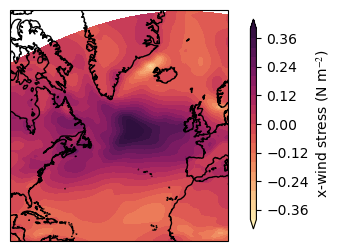

In [13]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (3, 3), subplot_kw = {'projection': projection})

p1 = axes.contourf(tauu_NA.geolon_t, tauu_NA.geolat_t, tauu_NA[0], levels = np.linspace(-0.4, 0.4, 21), 
                           cmap = cm.cm.matter, transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.02, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress (N m$^{-2}$)', fontsize = 10)

axes.set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
axes.coastlines(resolution = '50m')

In [14]:
# Compute anomalies
tauu_mean = tauu_NA.mean('time')
tauu_amly = tauu_NA - tauu_mean

In [15]:
# Compute EOF
coslat_tauu = np.cos(np.deg2rad(tauu_NA.yt_ocean.values))
wgts_tauu = np.sqrt(coslat_tauu)[..., np.newaxis]
solver_DJF_tauu = Eof(tauu_amly.drop(['geolon_t', 'geolat_t']), weights = wgts_tauu)
eof_DJF_tauu = solver_DJF_tauu.eofsAsCovariance(neofs = neofs)

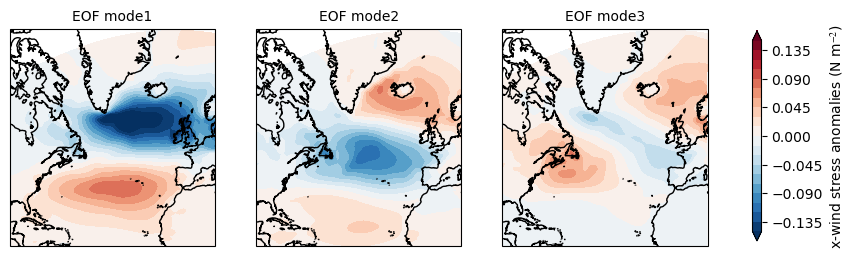

In [16]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(tauu_NA.geolon_t, tauu_NA.geolat_t, eof_DJF_tauu[0], levels = np.linspace(-0.15, 0.15, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p2 = axes[1].contourf(tauu_NA.geolon_t, tauu_NA.geolat_t, eof_DJF_tauu[1], levels = np.linspace(-0.15, 0.15, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p3 = axes[2].contourf(tauu_NA.geolon_t, tauu_NA.geolat_t, eof_DJF_tauu[2], levels = np.linspace(-0.15, 0.15, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress anomalies (N m$^{-2}$)', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title('EOF mode' + str(i+1), fontsize = 10)

In [17]:
print('Percentage of EOF explained by first ' + str(neigs) + ' modes:' + str(100 * np.round(solver_DJF_tauu.varianceFraction(neigs = neigs).values, 4)))

Percentage of EOF explained by first 3 modes:[43.26 20.16  7.13]


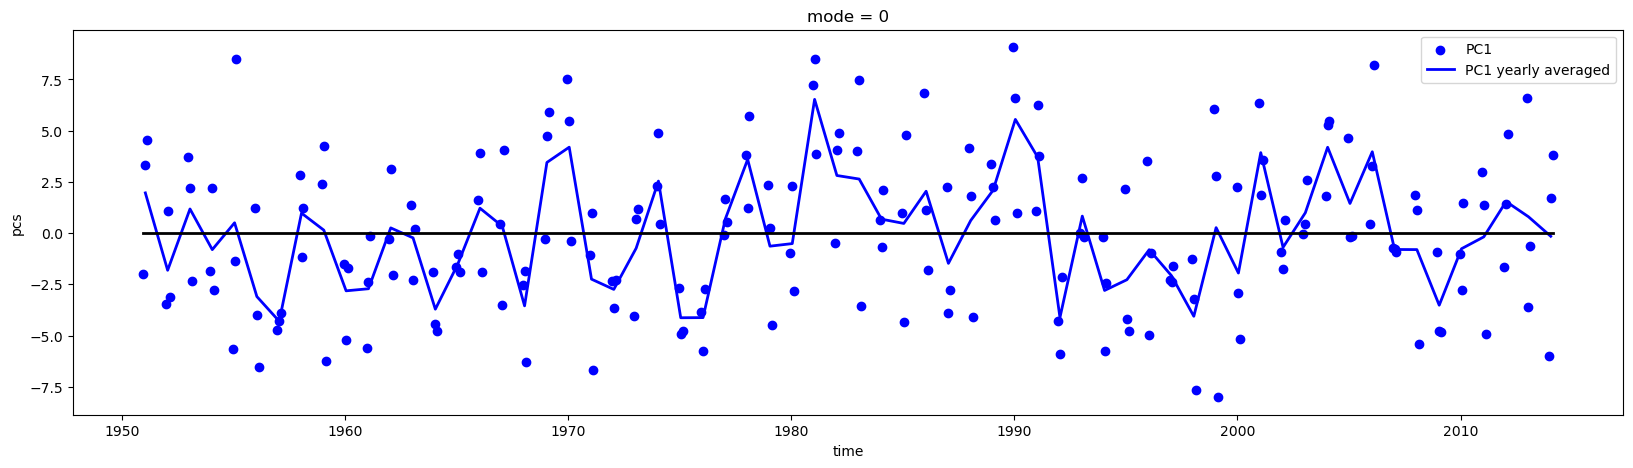

In [18]:
plt.figure(figsize = (20, 5))
#npcs = number of PCs, 
#pscaling = 0 -> unscaled variance scaling of PCs
#         = 1 -> scaled to unit variance
#         = 2 -> PC multiplied by the square root of their eigenvalue

pcs_tauu = solver_DJF_tauu.pcs(npcs = npcs, pcscaling = 0)
pcs_tauu.sel(mode = 0).plot.scatter(color = 'blue', label = 'PC1')
pcs_tauu.sel(mode = 0).coarsen(time = 3).mean().plot(color = 'blue', label = 'PC1 yearly averaged')
#pcs_tauu.sel(mode = 1).coarsen(time = 3).mean().plot(color = 'orange', label = 'PC2', ls = '--')
#pcs_tauu.sel(mode = 2).coarsen(time = 3).mean().plot(color = 'red', label = 'PC3', ls = '--')
plt.plot(pcs_tauu.sel(mode = 1).time, np.zeros(192), color = 'black')
plt.legend()

### Correlation between the first modes of geopotential height and wind stress

Correlation is 0.9035395319921421


Text(0.5, 1.0, 'Normalized PC (first mode) of geopotential height and wind stress')

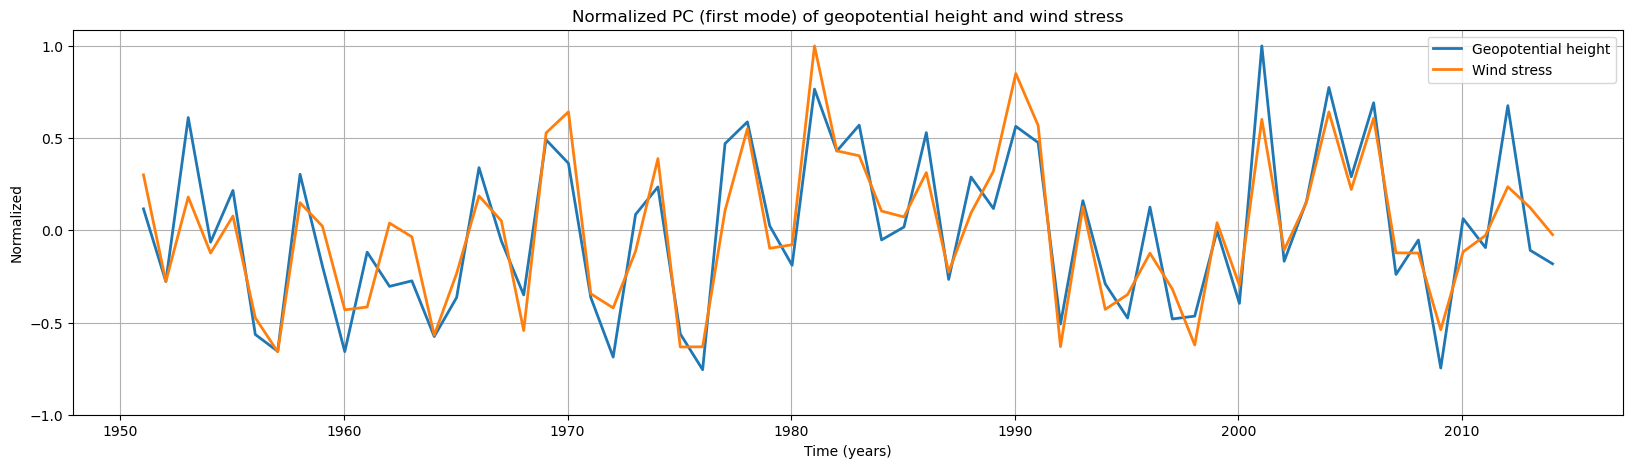

In [19]:
a = pcs_hgt_DJF.sel(mode = 0).coarsen(time = 3).mean()
b = pcs_tauu.sel(mode = 0).coarsen(time = 3).mean()

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Geopotential height')
(b/(np.max(b))).plot(label = 'Wind stress')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of geopotential height and wind stress')

## EOF for curl of wind stress

In [20]:
# Wind stress curl
dtauu_dy_NA = tauu_NA.differentiate('yt_ocean')*(180/np.pi)/r0
dtauu_dy_mean = dtauu_dy_NA.mean('time')
dtauu_dy_amly = dtauu_dy_NA - dtauu_dy_mean

In [21]:
coslat_dtauu_dy = np.cos(np.deg2rad(dtauu_dy_NA.geolat_t.values))
wgts_dtauu_dy = np.sqrt(coslat_dtauu_dy)[..., np.newaxis]
solver_DJF_dtauu_dy = Eof(dtauu_dy_amly.drop(['geolat_t', 'geolon_t']), weights = wgts_dtauu_dy)
eof_DJF_dtauu_dy = solver_DJF_dtauu_dy.eofsAsCovariance(neofs = neofs)

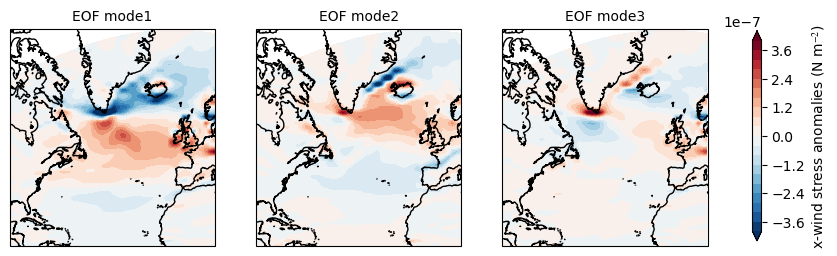

In [22]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(tauu_NA.geolon_t, tauu_NA.geolat_t, eof_DJF_dtauu_dy[0], levels = np.linspace(-4e-7, 4e-7, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p2 = axes[1].contourf(tauu_NA.geolon_t, tauu_NA.geolat_t, eof_DJF_dtauu_dy[1], levels = np.linspace(-4e-7, 4e-7, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p3 = axes[2].contourf(tauu_NA.geolon_t, tauu_NA.geolat_t, eof_DJF_dtauu_dy[2], levels = np.linspace(-4e-7, 4e-7, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('x-wind stress anomalies (N m$^{-2}$)', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title('EOF mode' + str(i+1), fontsize = 10)

In [23]:
## The eigenvalues are the variance explained by each EOF 
print('Percentage of EOF explained by first ' + str(neigs) + ' modes:' + str(100 * np.round(solver_DJF_dtauu_dy.varianceFraction(neigs = neigs).values, 4)))

Percentage of EOF explained by first 3 modes:[27.98      13.099999   6.4900002]


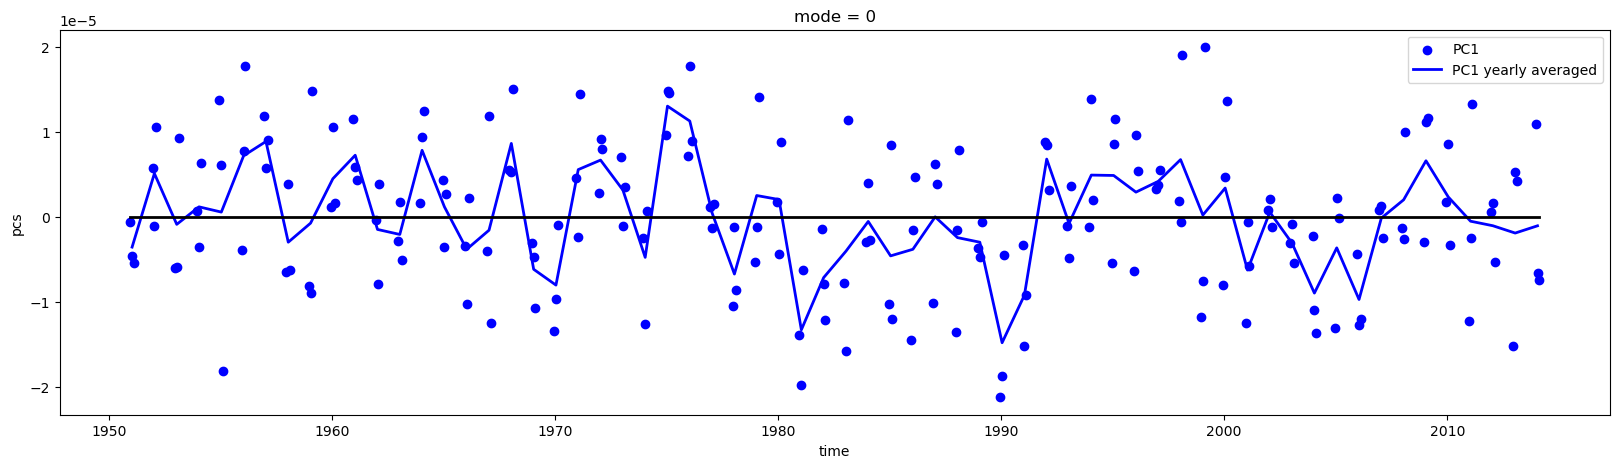

In [24]:
plt.figure(figsize = (20, 5))
#npcs = number of PCs, 
#pscaling = 0 -> unscaled variance scaling of PCs
#         = 1 -> scaled to unit variance
#         = 2 -> PC multiplied by the square root of their eigenvalue

pcs_dtauu_dy = solver_DJF_dtauu_dy.pcs(npcs = npcs, pcscaling = 0)
pcs_dtauu_dy.sel(mode = 0).plot.scatter(color = 'blue', label = 'PC1')
pcs_dtauu_dy.sel(mode = 0).coarsen(time = 3).mean().plot(color = 'blue', label = 'PC1 yearly averaged')
#pcs_dtauu_dy.sel(mode = 1).coarsen(time = 3).mean().plot(color = 'orange', label = 'PC2', ls = '--')
#pcs_dtauu_dy.sel(mode = 2).coarsen(time = 3).mean().plot(color = 'red', label = 'PC3', ls = '--')
plt.plot(pcs_dtauu_dy.sel(mode = 1).time, np.zeros(192), color = 'black')
plt.legend()

### Correlation between first modes of geopotential height and wind stress curl

Correlation is -0.8307712704090064


Text(0.5, 1.0, 'Normalized PC (first mode) of geopotential height and wind stress curl')

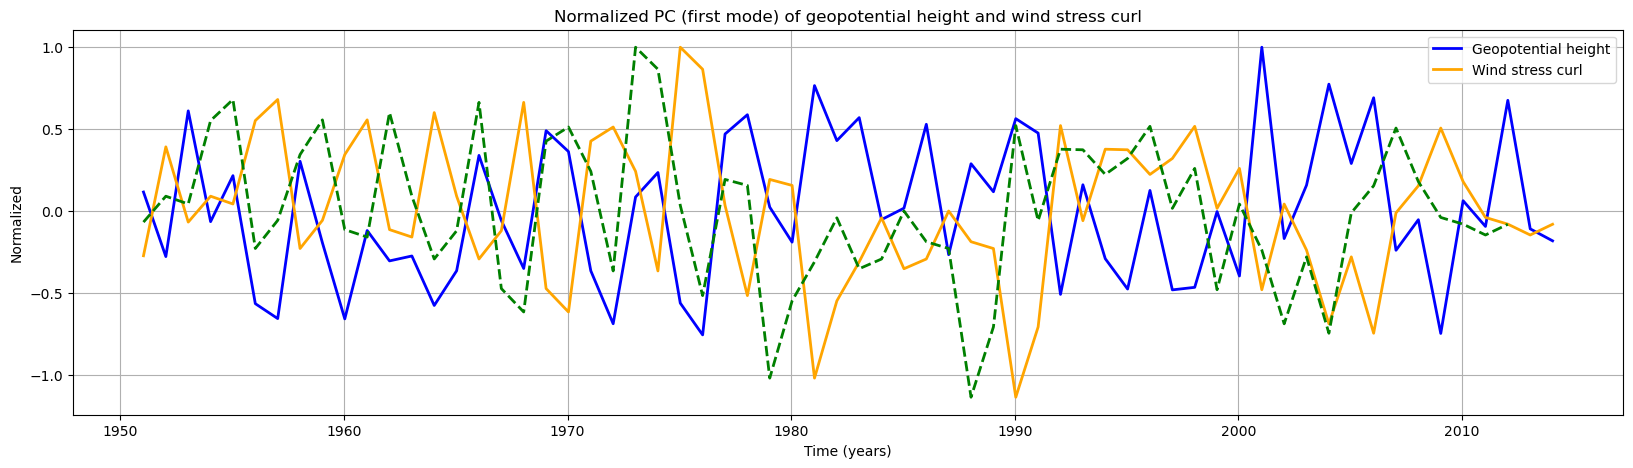

In [25]:
a = pcs_hgt_DJF.sel(mode = 0).coarsen(time = 3).mean()
b = pcs_dtauu_dy.sel(mode = 0).coarsen(time = 3).mean()

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Geopotential height', color = 'blue')
(b/(np.max(b))).plot(label = 'Wind stress curl', color = 'orange')
plt.plot(a.time[0:-2], b.values[2:]/np.max(b).values, color = 'green', ls = '--')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of geopotential height and wind stress curl')

## NA Gyre strength

Next, we look at the North Atlantic subtropical gyre strength.

In [26]:
yr_start = int(start_time[0:4])
yr_end = int(end_time[0:4])

for i in range(yr_start, yr_end, 10):
    start = str(i)
    if(i!=2010):
        end = str(i+9)
    elif(i == 2010):
        end = str(i+4)
        
    umo_da = xr.open_dataset(dir + '/' + scenario + '/' + run + '/Omon/umo/gn/latest/umo_Omon_ACCESS-CM2_' + scenario + '_' + run + '_gn_' + start + '01-' + end + '12.nc').umo
    if(i == 1950):
        umo_da_total = umo_da
    else:
        umo_da_total = xr.concat([umo_da_total, umo_da], 'time')

umo_da_total = umo_da_total.sel(time = slice(start_time, end_time))

# Vertically integrating to compute barotropic streamfunction
umo_da_total = umo_da_total.sum('lev')

# Regridding to proper grid
umo_da_total = regridder(umo_da_total, 'ocean')

# Selecting Dec, Jan and Feb months
umo = umo_da_total.where(umo_da_total.time.dt.month.isin([12, 1, 2]), drop = True)

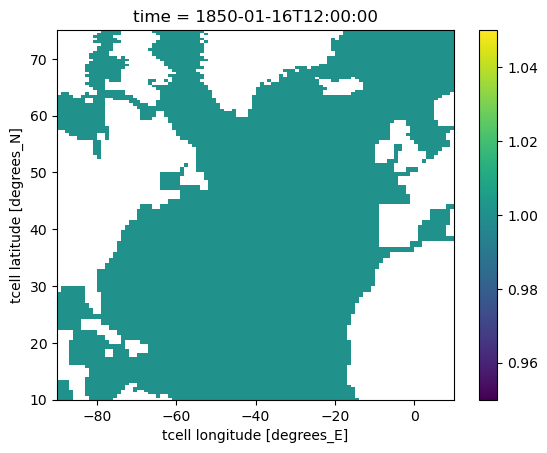

In [27]:
mask = xr.open_dataset(dir + '/' + scenario + '/' + run + '/Omon/pso/gn/latest/pso_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc').pso[0]
mask = (mask+20)/(mask+20)
mask = regridder(mask, 'ocean')
mask = mask.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
mask.plot()

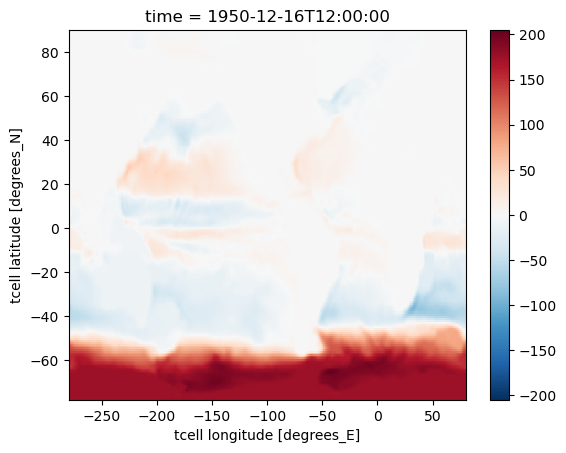

In [28]:
# Calculate barotropic streamfunction
Ψ = -umo.cumsum('yt_ocean')/(m3_to_Sv * ρ0)
Ψ_ACC = np.nanmin(Ψ.mean('time').sel(xt_ocean = slice(-69, -67), yt_ocean = slice(-80, -55)))
Ψ_g = Ψ - Ψ_ACC
Ψ_g[0].plot()

In [29]:
# Compute anomalies
Ψ_g_DJF = Ψ_g.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max)) * mask
Ψ_g_DJF_mean = Ψ_g_DJF.mean('time')
Ψ_g_DJF_amly = Ψ_g_DJF - Ψ_g_DJF_mean

In [30]:
# Compute EOF for barotropic streamfunction
coslat_Ψ_g = np.cos(np.deg2rad(Ψ_g_DJF.yt_ocean.values))
wgts_Ψ_g = np.sqrt(coslat_Ψ_g)[..., np.newaxis]
solver_DJF_Ψ_g = Eof(Ψ_g_DJF_amly.drop(['geolon_t', 'geolat_t']), weights = wgts_Ψ_g)
eof_DJF_Ψ_g = solver_DJF_Ψ_g.eofsAsCovariance(neofs = neofs)

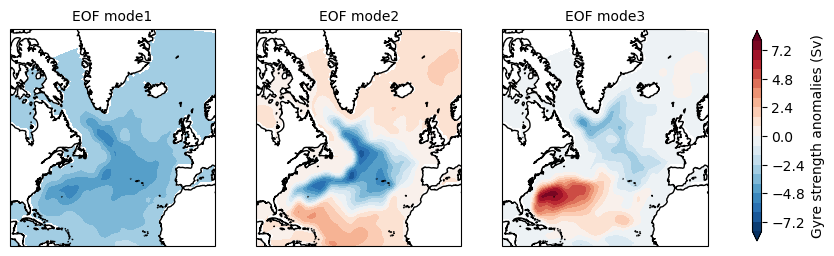

In [31]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(Ψ_g_DJF.geolon_t, Ψ_g_DJF.geolat_t, eof_DJF_Ψ_g[0], levels = np.linspace(-8, 8, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p2 = axes[1].contourf(Ψ_g_DJF.geolon_t, Ψ_g_DJF.geolat_t, eof_DJF_Ψ_g[1], levels = np.linspace(-8, 8, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p3 = axes[2].contourf(Ψ_g_DJF.geolon_t, Ψ_g_DJF.geolat_t, eof_DJF_Ψ_g[2], levels = np.linspace(-8, 8, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Gyre strength anomalies (Sv)', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title('EOF mode' + str(i+1), fontsize = 10)

In [32]:
## The eigenvalues are the variance explained by each EOF 
print('Percentage of EOF explained by first ' + str(neigs) + ' modes:' + str(100 * np.round(solver_DJF_Ψ_g.varianceFraction(neigs = neigs).values, 4)))

Percentage of EOF explained by first 3 modes:[45.73 17.66 10.74]


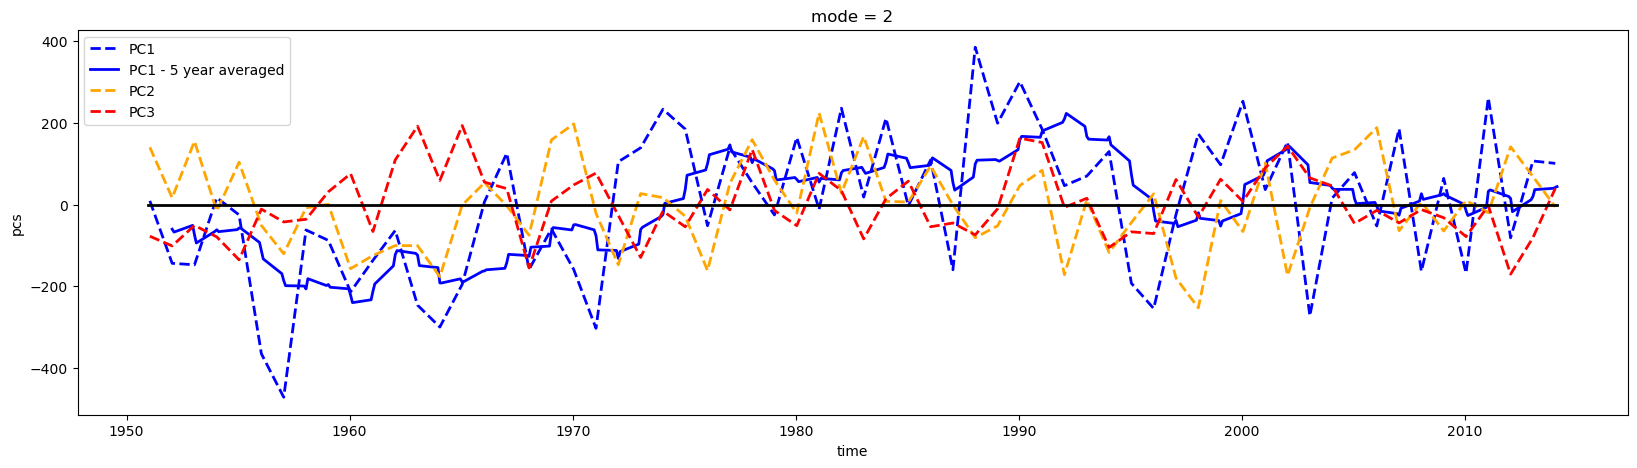

In [33]:
plt.figure(figsize = (20, 5))
#npcs = number of PCs, 
#pscaling = 0 -> unscaled variance scaling of PCs
#         = 1 -> scaled to unit variance
#         = 2 -> PC multiplied by the square root of their eigenvalue

pcs_Ψ_g = solver_DJF_Ψ_g.pcs(npcs = npcs, pcscaling = 0)
pcs_Ψ_g.sel(mode = 0).coarsen(time = 3).mean().plot(color = 'blue', label = 'PC1', ls = '--')
pcs_Ψ_g.sel(mode = 0).rolling(time = 15, min_periods = 5).mean().plot(color = 'blue', label = 'PC1 - 5 year averaged')
pcs_Ψ_g.sel(mode = 1).coarsen(time = 3).mean().plot(color = 'orange', label = 'PC2', ls = '--')
pcs_Ψ_g.sel(mode = 2).coarsen(time = 3).mean().plot(color = 'red', label = 'PC3', ls = '--')
plt.plot(pcs_Ψ_g.sel(mode = 1).time, np.zeros(192), color = 'black')
plt.legend()

### Correlation between first mode of wind stress curl and second mode of gyre strength

Correlation is -0.7016826445072576


Text(0.5, 1.0, 'Normalized PC (first mode) of wind stress curl and gyre strength')

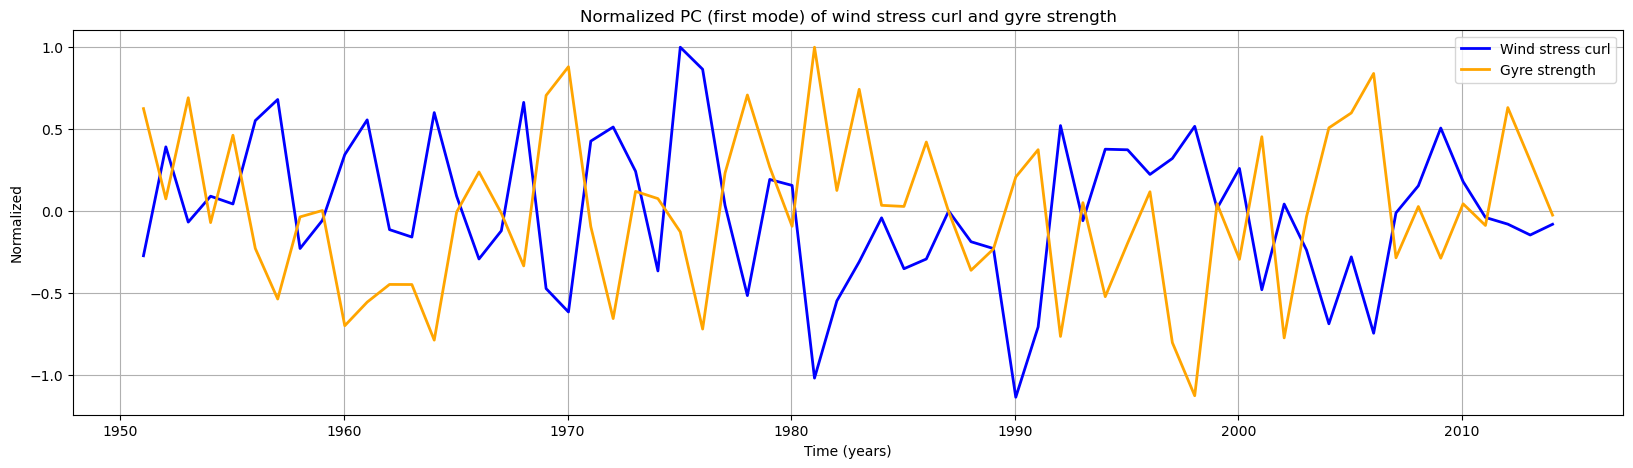

In [34]:
a = pcs_dtauu_dy.sel(mode = 0).coarsen(time = 3).mean()
b = pcs_Ψ_g.sel(mode = 1).coarsen(time = 3).mean()

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Wind stress curl', color = 'blue')
(b/(np.max(b))).plot(label = 'Gyre strength', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of wind stress curl and gyre strength')

### Correlation between first mode of wind stress and second mode of gyre strength

Correlation is 0.8010997056294467


Text(0.5, 1.0, 'Normalized PC (first mode) of wind stress and gyre strength')

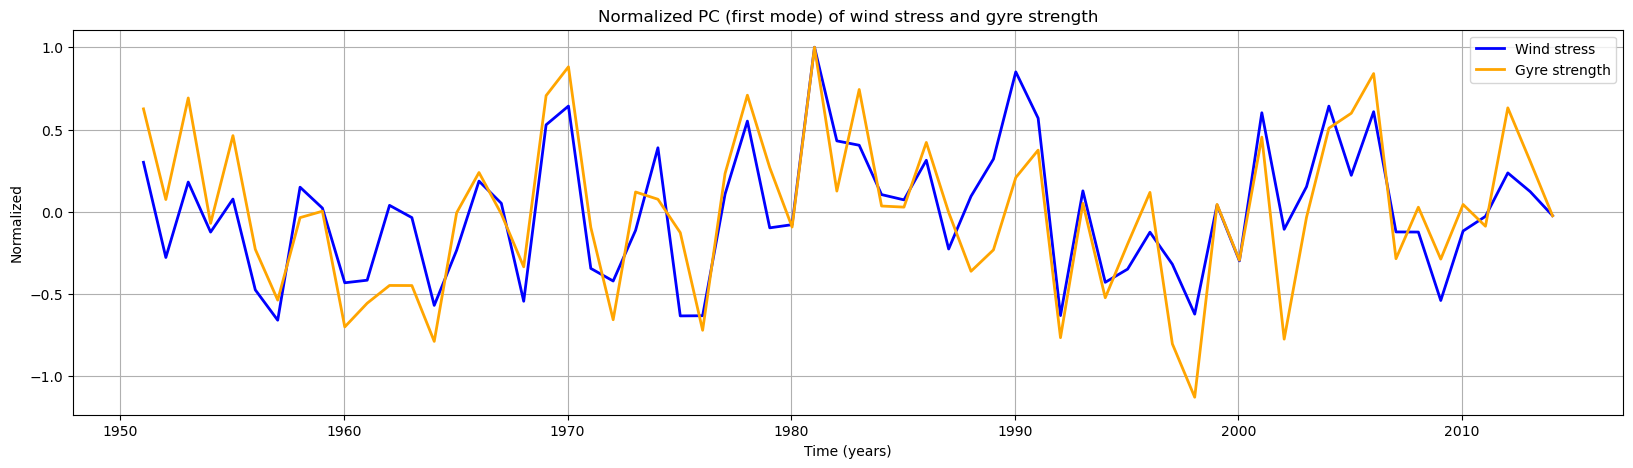

In [35]:
a = pcs_tauu.sel(mode = 0).coarsen(time = 3).mean()
b = pcs_Ψ_g.sel(mode = 1).coarsen(time = 3).mean()

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Wind stress', color = 'blue')
(b/(np.max(b))).plot(label = 'Gyre strength', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of wind stress and gyre strength')

### Correlation between first mode of geopotential height and second mode of gyre strength

Correlation is 0.8139565449093181


Text(0.5, 1.0, 'Normalized PC (first mode) of wind stress curl and gyre strength')

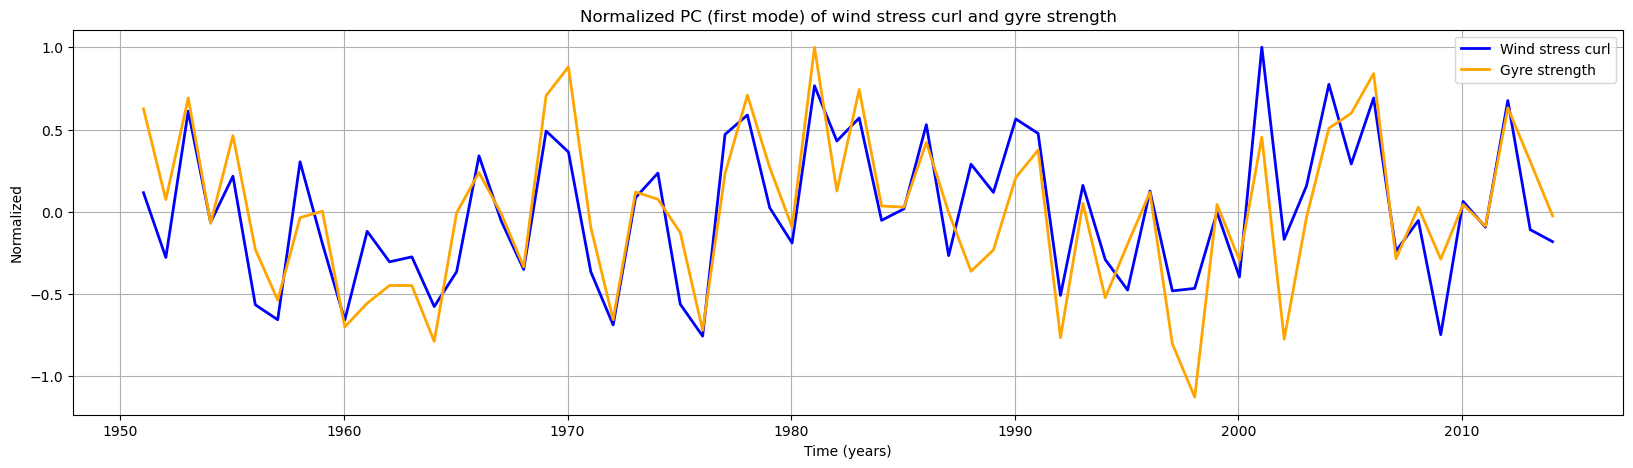

In [36]:
a = pcs_hgt_DJF.sel(mode = 0).coarsen(time = 3).mean()
b = pcs_Ψ_g.sel(mode = 1).coarsen(time = 3).mean()

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Wind stress curl', color = 'blue')
(b/(np.max(b))).plot(label = 'Gyre strength', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of wind stress curl and gyre strength')

## Getting gyre strength using a pseudo-streamfunction for 0-1100 m depth 

In the previous section, we performed an EOF analysis for each variable. A more physical approach is to calculate the barotropic streamfunction and check its correlation with the first EOF of geopotential height, wind stress, and wind stress curl. We also don't do the EOF analysis here, instead compute the correlations directly.

In [101]:
yr_start = 1950
yr_end = 2020
for i in range(yr_start, yr_end, 10):
    start = str(i)
    if(i!=2010):
        end = str(i+9)
    elif(i == 2010):
        end = str(i+4)
        
    vmo_da = xr.open_dataset(dir + '/' + scenario + '/' + run + '/Omon/vmo/gn/latest/vmo_Omon_ACCESS-CM2_' + scenario + '_' + run + '_gn_' + start + '01-' + end + '12.nc').vmo
    if(i == 1950):
        vmo_da_total = vmo_da
    else:
        vmo_da_total = xr.concat([vmo_da_total, vmo_da], 'time')

vmo_da_total = vmo_da_total.sel(time = slice(start_time, end_time))
vmo_da_top = vmo_da_total.sel(lev = slice(0, 1100)).sum('lev')
vmo = regridder(vmo_da_top, 'ocean')

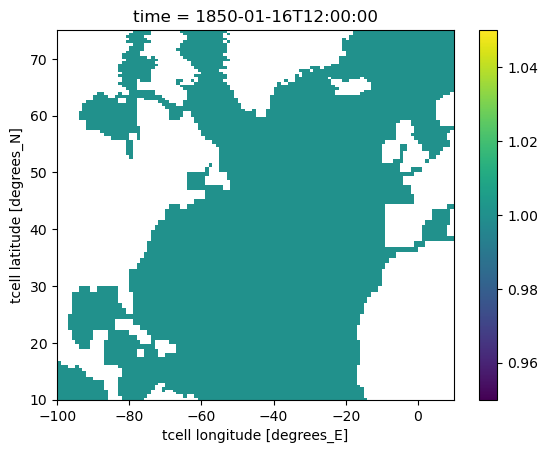

In [102]:
mask2 = xr.open_dataset(dir + '/' + scenario + '/' + run + '/Omon/pso/gn/latest/pso_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-201412.nc').pso[0]
mask2 = (mask2+20)/(mask2+20)
mask2 = regridder(mask2, 'ocean')
mask2 = mask2.sel(xt_ocean = slice(-100, x_max)).sel(yt_ocean = slice(y_min, y_max))
mask2.plot()

In [103]:
## North Atlantic coordinates

vmo_NA = vmo.sel(xt_ocean = slice(-100, x_max)).sel(yt_ocean = slice(y_min, y_max)).where(vmo.time.dt.month.isin([12, 1, 2]), drop = True)
Ψ_NA = vmo_NA.cumsum('xt_ocean') * mask2

In [104]:
from sklearn import preprocessing

area_cello = xr.open_dataset('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/' + 
                             'Ofx/areacello/gn/latest/areacello_Ofx_ACCESS-CM2_historical_r1i1p1f1_gn.nc').areacello
area_cello = regridder_ocean_to_ocean(area_cello).sel(xt_ocean = slice(-100, x_max)).sel(yt_ocean = slice(y_min, y_max))
area_cello_normalize = preprocessing.normalize(area_cello)
area_cello_normalize = area_cello_normalize * mask2
Ψ_mag = Ψ_NA.weighted(area_cello_normalize.fillna(0)).quantile(0.95, dim = {"yt_ocean", "xt_ocean"})/(m3_to_Sv * ρ0)

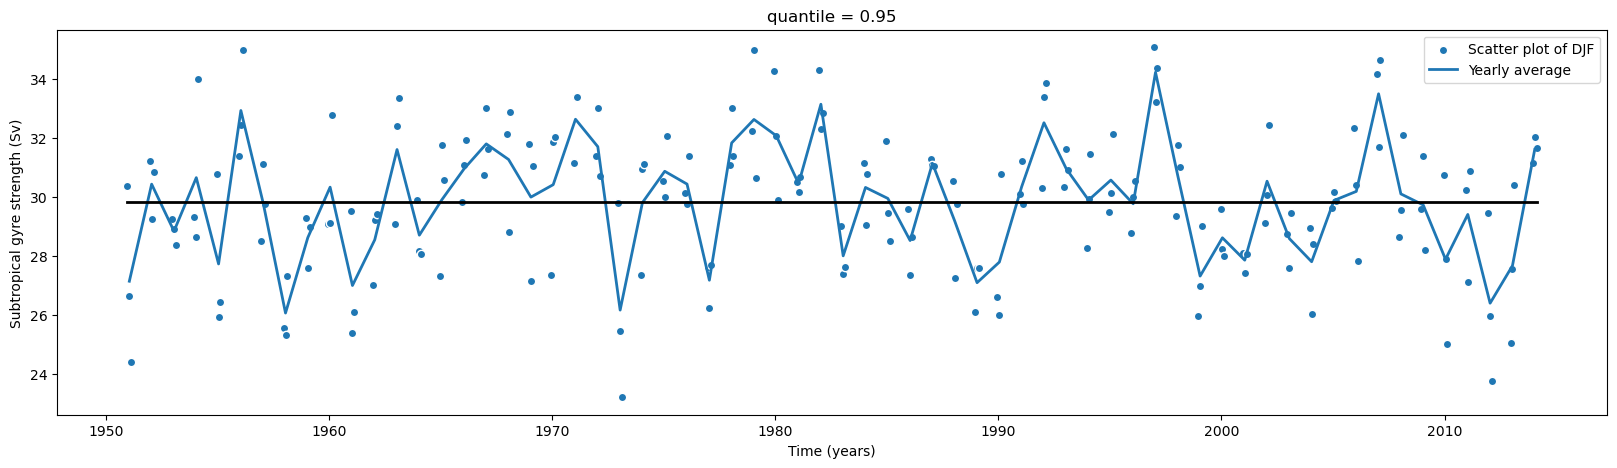

In [107]:
plt.figure(figsize = (20, 5))
Ψ_mag.plot.scatter(label = 'Scatter plot of DJF')
Ψ_mag.coarsen(time = 3).mean().plot(label = 'Yearly average')
plt.plot(Ψ_mag.time, Ψ_mag.mean('time').values * np.ones(192), color = 'black')
plt.ylabel('Subtropical gyre strength (Sv)')
plt.xlabel('Time (years)')
plt.legend()

### Correlation betweeen first mode of wind stress curl and alternative gyre strength 

Correlation is 0.20483688385436885


Text(0.5, 1.0, 'Normalized PC (first mode) of wind stress curl and gyre strength')

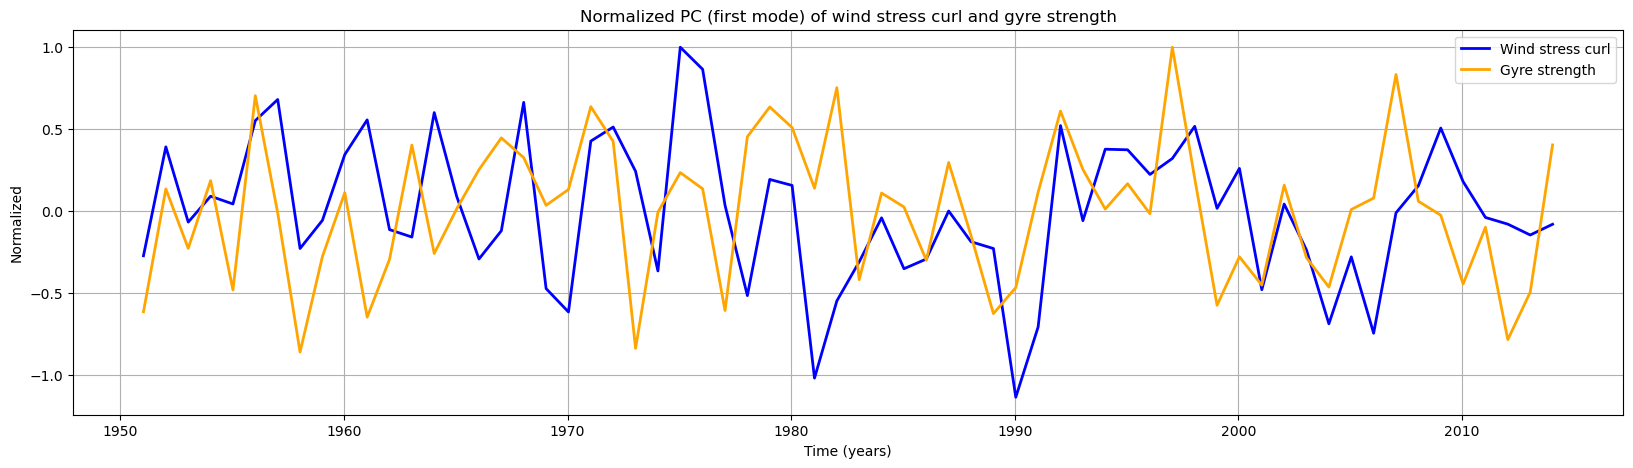

In [112]:
a = pcs_dtauu_dy.sel(mode = 0).coarsen(time = 3).mean()
b1 = Ψ_mag.coarsen(time = 3).mean()
b1 = b1 - b1.mean()

year_lag = 1
b2 = Ψ_mag.coarsen(time = 3).mean()[year_lag:].values
b2 = b2 - np.mean(b2)

print('Correlation is ' + str(xr.corr(a, b1).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Wind stress curl', color = 'blue')
(b1/(np.max(b1))).plot(label = 'Gyre strength', color = 'orange')
#plt.plot(a.time[:-1], b2/np.max(b1).values, label = 'Gyre strength shifted by 1 year', color = 'orange', ls = '--')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of wind stress curl and gyre strength')

### Correlation between first mode of wind stress and alternative gyre strength

Correlation is -0.2766838538768797


Text(0.5, 1.0, 'Normalized PC (first mode) of wind stress and gyre strength')

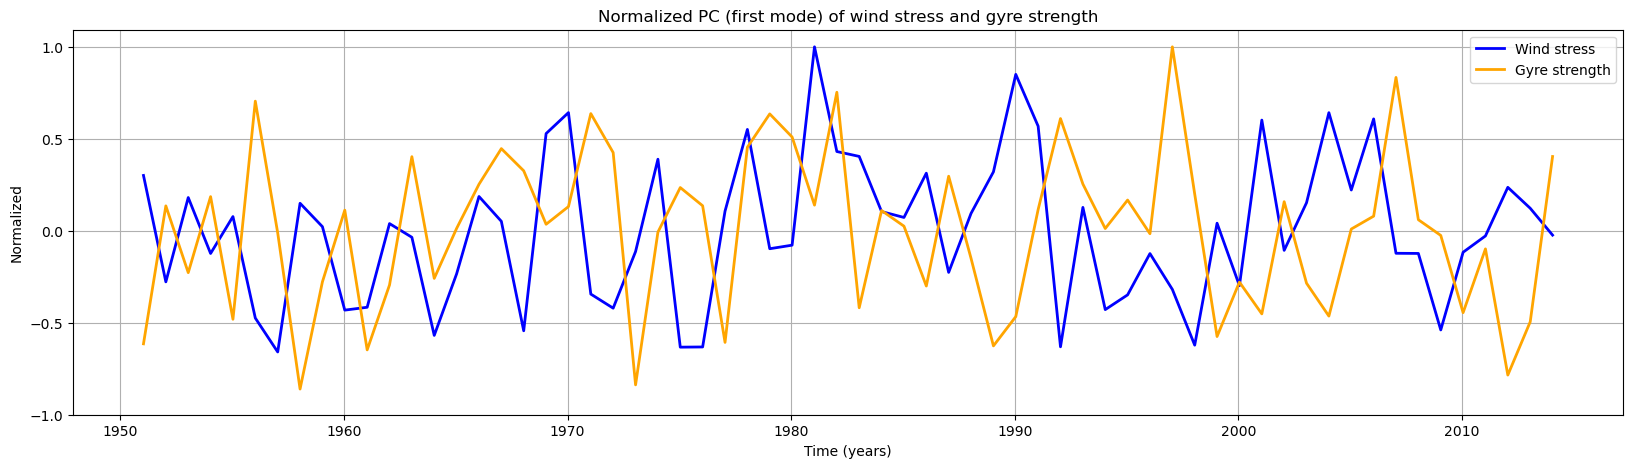

In [114]:
a = pcs_tauu.sel(mode = 0).coarsen(time = 3).mean()
b = Ψ_mag.coarsen(time = 3).mean()
b = b - b.mean()

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Wind stress', color = 'blue')
(b/(np.max(b))).plot(label = 'Gyre strength', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of wind stress and gyre strength')

### Correlation between first mode of geopotential height and alternative gyre strength

Correlation is -0.38302318862557183


Text(0.5, 1.0, 'Normalized PC (first mode) of geopotential height and gyre strength')

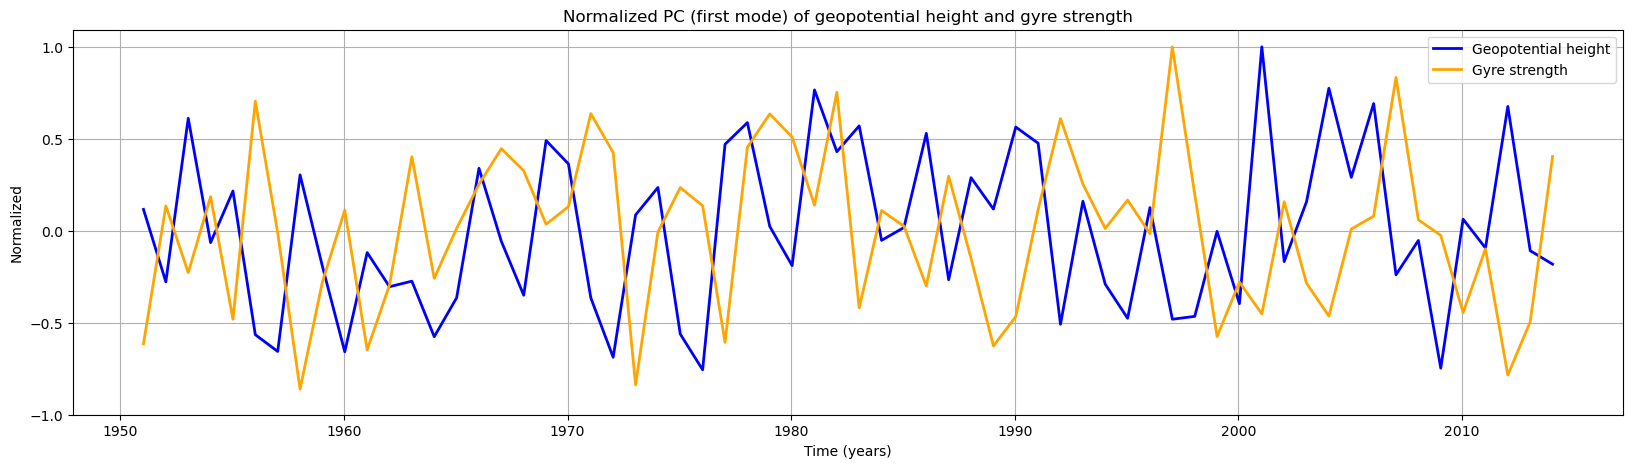

In [115]:
a = pcs_hgt_DJF.sel(mode = 0).coarsen(time = 3).mean()
b = Ψ_mag.coarsen(time = 3).mean()
b = b - b.mean()

print('Correlation is ' + str(xr.corr(a, b).values))

plt.figure(figsize = (20, 5))
(a/(np.max(a))).plot(label = 'Geopotential height', color = 'blue')
(b/(np.max(b))).plot(label = 'Gyre strength', color = 'orange')

plt.xlabel('Time (years)')
plt.ylabel('Normalized')
plt.grid()
plt.legend()
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.title('Normalized PC (first mode) of geopotential height and gyre strength')

# Moment of truth: Pointwise correlations between NAOi and gyre strength

We check the slope, correlations, and the p-value for 6 regions in the North Atlantic Ocean. These metrics are computed to understand the relationship (and its robustness) between the subtropical gyre strength and NAOi. The six regions are:

|Case No.|Lon|Lat|
|--------|----|----|
|1       |-60 |25  |
|2       |-60 |30  |
|3       |-30 |20  |
|4       |-60 |40  |
|5       |-40 |40  |
|4       |-40 |30  |

In [169]:
# Function that linearly regresses for a given time series
def dpsi_pred_func(a, m, c):
    dpsi_pred = m*a+c
    return dpsi_pred

# List of coordinates to check
x_val = [-60, -60, -30, -60, -40, -40]
y_val = [25, 30, 20, 40, 40, 30]

## Barotropic gyre strength case

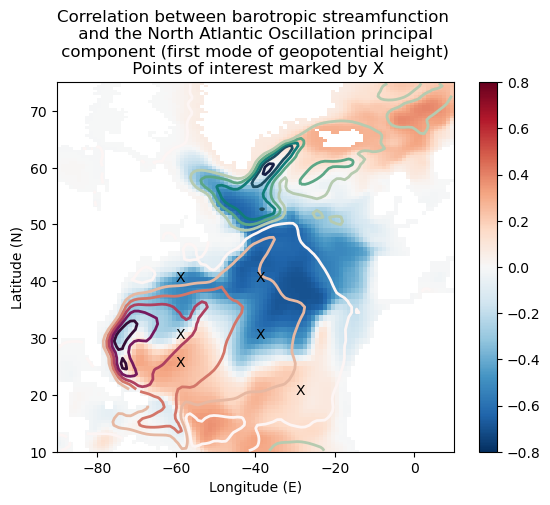

In [228]:
a = pcs_hgt_DJF.sel(mode = 0)
b = Ψ_g_DJF

xr.corr(a, b, 'time').plot(vmin = -0.8, vmax = 0.8, cmap = 'RdBu_r')

Ψ_g_DJF.mean('time').plot.contour(levels = np.linspace(-30, 30, 11), cmap = cm.cm.curl)
plt.xlabel('Longitude (E)')
plt.ylabel('Latitude (N)')
for i in range(len(x_val)):
    plt.text(x = x_val[i], y = y_val[i], s = 'X', color = 'black')
plt.title('Correlation between barotropic streamfunction \n and the North Atlantic Oscillation principal \n component (first mode of geopotential height) \n Points of interest marked by X');

Text(0.5, 1.0, 'Bathymetry')

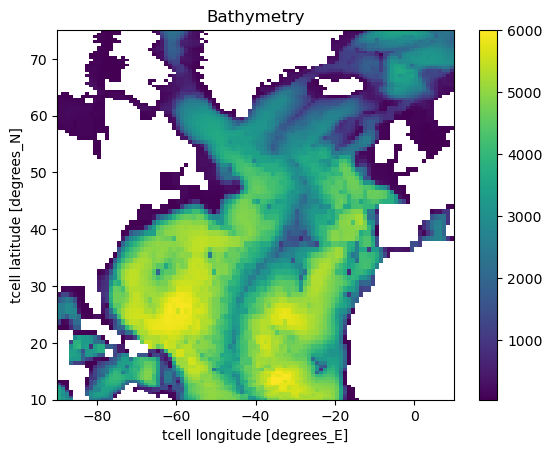

In [233]:
depth = xr.open_dataset(dir + '/' + scenario + '/' + run + '/Ofx/deptho/gn/latest/deptho_Ofx_ACCESS-CM2_' + scenario + '_' + run + '_gn.nc').deptho
depth = regridder(depth, 'ocean')
depth_NA = depth.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
depth_NA.plot()
plt.title('Bathymetry')

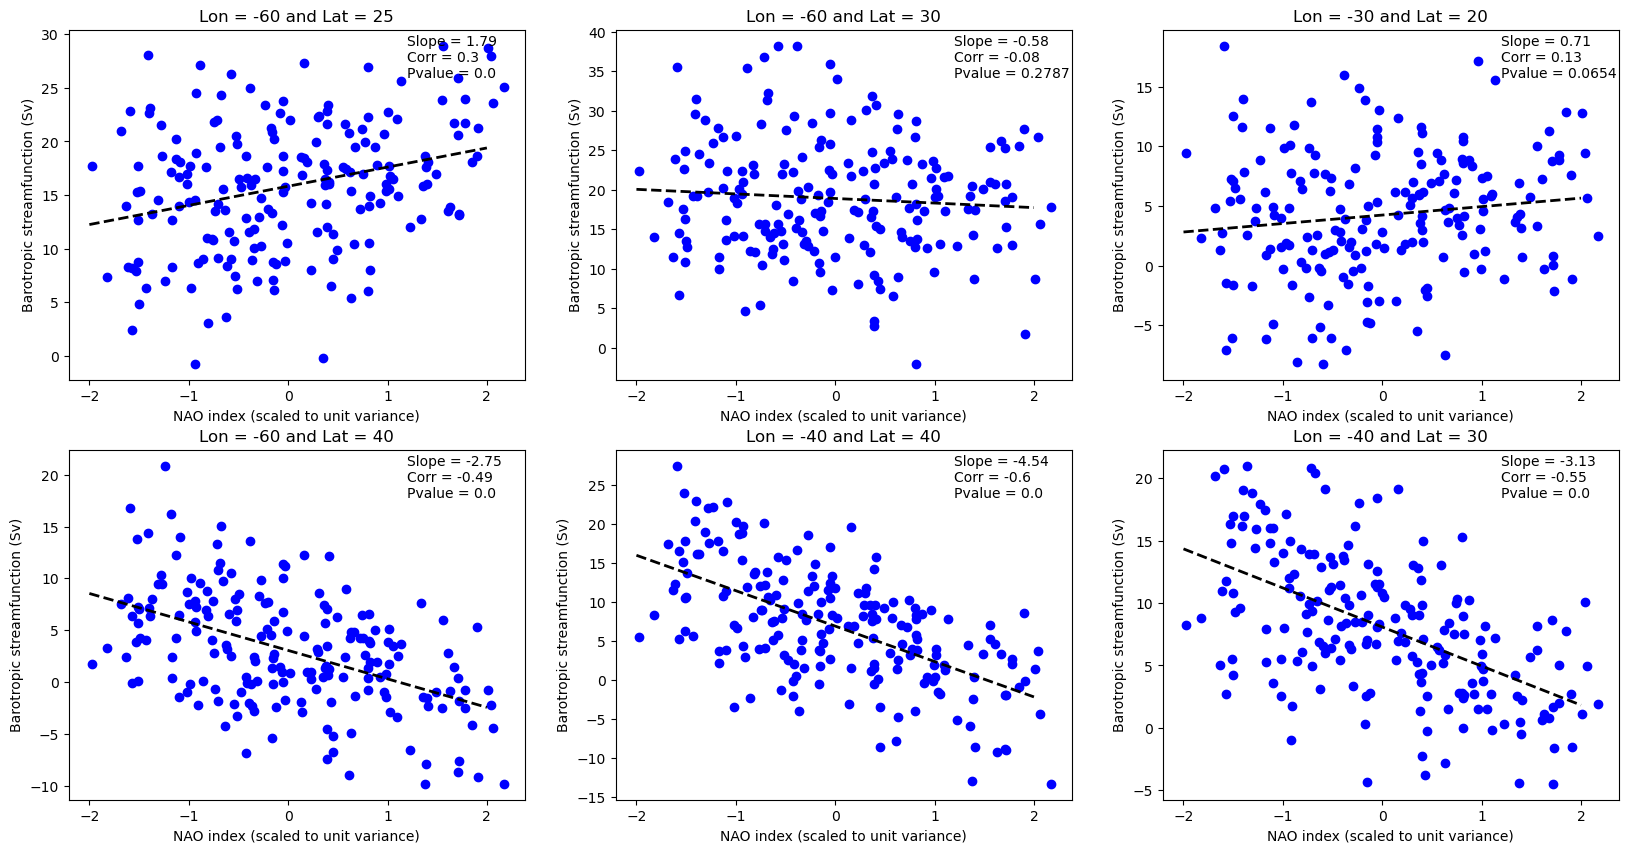

In [229]:
guess = np.array([1, 1])
x = np.linspace(-2, 2, 10)

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))
for i in range(len(x_val)):

    a = solver_DJF.pcs(npcs = npcs, pcscaling = 1).sel(mode = 0).values
    b = Ψ_g_DJF.sel(xt_ocean = x_val[i], method = 'nearest').sel(yt_ocean = y_val[i], method = 'nearest').values
    slope, const = curve_fit(dpsi_pred_func, a, b, guess)[0]
    corr, pvalue = stats.pearsonr(a, b)

    axes[int(i/3)][int(i%3)].scatter(a, b, color = 'blue')
    y = dpsi_pred_func(x, slope, const)
    axes[int(i/3)][int(i%3)].plot(x, y, color = 'black', ls = '--')
    axes[int(i/3)][int(i%3)].set_ylabel('Barotropic streamfunction (Sv)')
    axes[int(i/3)][int(i%3)].set_xlabel('NAO index (scaled to unit variance)')

    Ψmax = b.max()
    Ψmin = b.min()
    Ψdiff = Ψmax - Ψmin

    axes[int(i/3)][int(i%3)].text(1.2, Ψmax, s = 'Slope = ' + str(np.round(slope, 2)))
    axes[int(i/3)][int(i%3)].text(1.2, Ψmax - 0.05*(Ψdiff), s = 'Corr = ' + str(np.round(corr, 2)))
    axes[int(i/3)][int(i%3)].text(1.2, Ψmax - 0.10*(Ψdiff), s = 'Pvalue = '  + str(np.round(pvalue,  4)))

    axes[int(i/3)][int(i%3)].set_title('Lon = ' + str(x_val[i]) + ' and Lat = ' + str(y_val[i]))

### Is there a time-lagged correlation?

Below we check 1 month, 1 year, and 2 year lag (gyre strength shifted forwards in time) correlations with the first principal component of geopotential height.

In [62]:
Ψ_g_DJF_1mtlag = xr.DataArray(Ψ_g_DJF[1:], coords = [Ψ_g_DJF.time[0:-1], Ψ_g_DJF.yt_ocean, Ψ_g_DJF.xt_ocean],  dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'Psi', attrs = {'units':'Sv'})
Ψ_g_DJF_1yrlag = xr.DataArray(Ψ_g_DJF[3:], coords = [Ψ_g_DJF.time[0:-3], Ψ_g_DJF.yt_ocean, Ψ_g_DJF.xt_ocean],  dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'Psi', attrs = {'units':'Sv'})
Ψ_g_DJF_2yrlag = xr.DataArray(Ψ_g_DJF[6:], coords = [Ψ_g_DJF.time[0:-6], Ψ_g_DJF.yt_ocean, Ψ_g_DJF.xt_ocean],  dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'Psi', attrs = {'units':'Sv'})

Text(0.5, 1.0, '2 year lag')

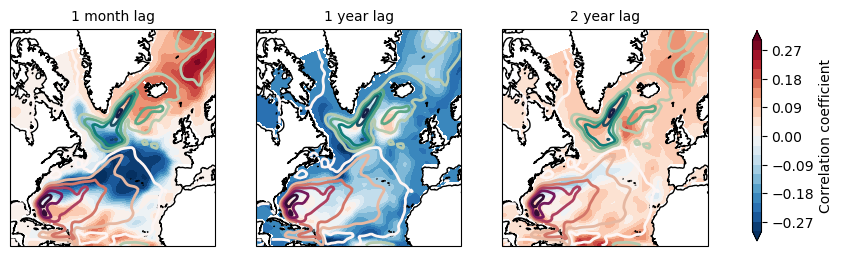

In [93]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

clev = np.linspace(-0.3, 0.3, 21)
p1 = axes[0].contourf(Ψ_g_DJF.geolon_t, Ψ_g_DJF.geolat_t, xr.corr(pcs_hgt_DJF.sel(mode = 0), Ψ_g_DJF_1mtlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')
p2 = axes[1].contourf(Ψ_g_DJF.geolon_t, Ψ_g_DJF.geolat_t, xr.corr(pcs_hgt_DJF.sel(mode = 0), Ψ_g_DJF_1yrlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')
p3 = axes[2].contourf(Ψ_g_DJF.geolon_t, Ψ_g_DJF.geolat_t, xr.corr(pcs_hgt_DJF.sel(mode = 0), Ψ_g_DJF_2yrlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')

for i in range(3):
    axes[i].contour(Ψ_g_DJF.geolon_t, Ψ_g_DJF.geolat_t, Ψ_g_DJF.mean('time'), cmap = cm.cm.curl, levels = np.linspace(-30, 30, 11), transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Correlation coefficient', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    
axes[0].set_title('1 month lag', fontsize = 10)
axes[1].set_title('1 year lag', fontsize = 10)
axes[2].set_title('2 year lag', fontsize = 10)

## 0-1100 m depth gyre strength case

Text(0.5, 1.0, 'Correlation between 0-1100m streamfunction \n and the North Atlantic Oscillation principal \n component (first mode of geopotential height)')

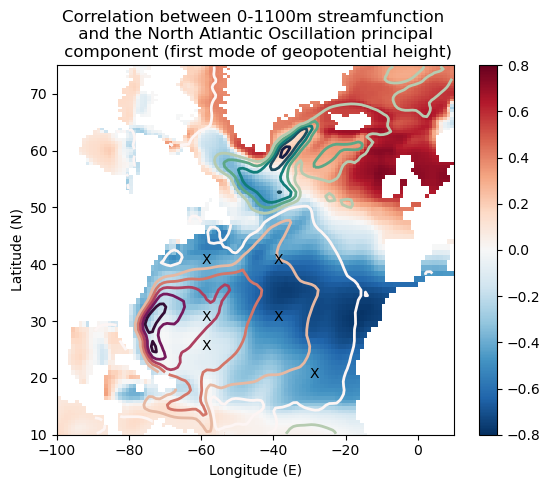

In [232]:
a = pcs_hgt_DJF.sel(mode = 0)
b = Ψ_NA

xr.corr(a, b, 'time').plot(vmin = -0.8, vmax = 0.8, cmap = 'RdBu_r')

Ψ_g_DJF.mean('time').plot.contour(levels = np.linspace(-30, 30, 11), cmap = cm.cm.curl)
plt.xlabel('Longitude (E)')
plt.ylabel('Latitude (N)')
for i in range(len(x_val)):
    plt.text(x = x_val[i], y = y_val[i], s = 'X', color = 'black')
plt.title('Correlation between 0-1100m streamfunction \n and the North Atlantic Oscillation principal \n component (first mode of geopotential height)')

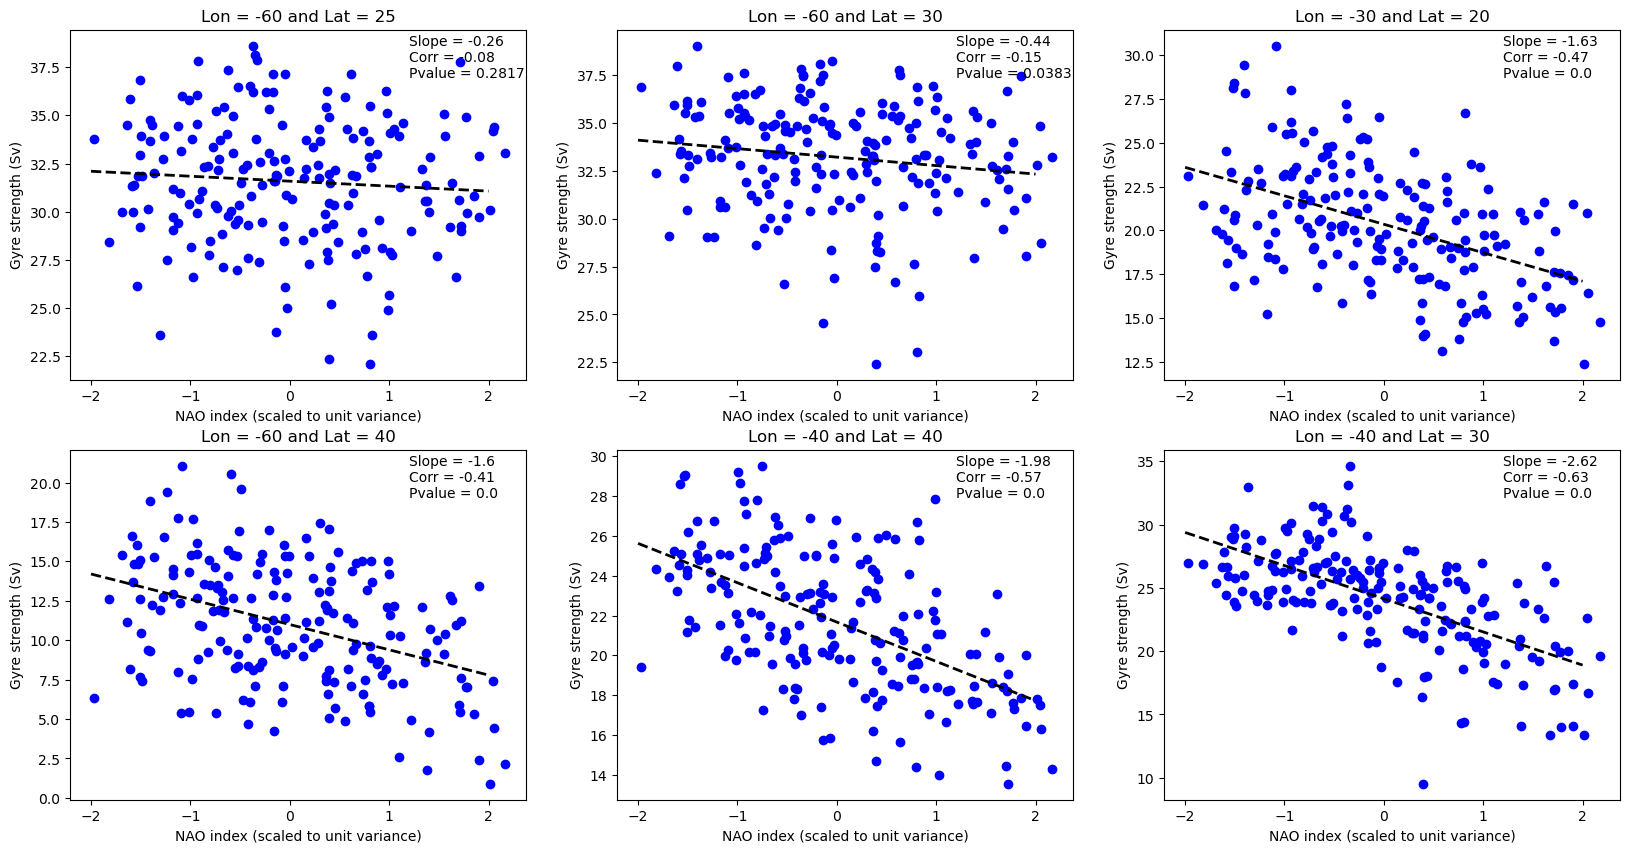

In [230]:
guess = np.array([1, 1])
x = np.linspace(-2, 2, 10)

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 10))
for i in range(len(x_val)):

    a = solver_DJF.pcs(npcs = npcs, pcscaling = 1).sel(mode = 0).values
    b = Ψ_NA.sel(xt_ocean = x_val[i], method = 'nearest').sel(yt_ocean = y_val[i], method = 'nearest').values / (ρ0 * m3_to_Sv)
    slope, const = curve_fit(dpsi_pred_func, a, b, guess)[0]
    corr, pvalue = stats.pearsonr(a, b)

    axes[int(i/3)][int(i%3)].scatter(a, b, color = 'blue')
    y = dpsi_pred_func(x, slope, const)
    axes[int(i/3)][int(i%3)].plot(x, y, color = 'black', ls = '--')
    axes[int(i/3)][int(i%3)].set_ylabel('Gyre strength (Sv)')
    axes[int(i/3)][int(i%3)].set_xlabel('NAO index (scaled to unit variance)')

    Ψmax = b.max()
    Ψmin = b.min()
    Ψdiff = Ψmax - Ψmin

    axes[int(i/3)][int(i%3)].text(1.2, Ψmax, s = 'Slope = ' + str(np.round(slope, 2)))
    axes[int(i/3)][int(i%3)].text(1.2, Ψmax - 0.05*(Ψdiff), s = 'Corr = ' + str(np.round(corr, 2)))
    axes[int(i/3)][int(i%3)].text(1.2, Ψmax - 0.10*(Ψdiff), s = 'Pvalue = '  + str(np.round(pvalue,  4)))

    axes[int(i/3)][int(i%3)].set_title('Lon = ' + str(x_val[i]) + ' and Lat = ' + str(y_val[i]))

### Is there a time-lagged correlation?

Below we check 1 month, 1 year, and 2 year lag (gyre strength shifted forwards in time) correlations with the first principal component of geopotential height.

In [210]:
Ψ_NA_1mtlag = xr.DataArray(Ψ_NA[1:]/(ρ0 * m3_to_Sv), coords = [Ψ_NA.time[0:-1], Ψ_NA.yt_ocean, Ψ_NA.xt_ocean],  dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'Psi', attrs = {'units':'Sv'})
Ψ_NA_1yrlag = xr.DataArray(Ψ_NA[3:]/(ρ0 * m3_to_Sv), coords = [Ψ_NA.time[0:-3], Ψ_NA.yt_ocean, Ψ_NA.xt_ocean],  dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'Psi', attrs = {'units':'Sv'})
Ψ_NA_2yrlag = xr.DataArray(Ψ_NA[6:]/(ρ0 * m3_to_Sv), coords = [Ψ_NA.time[0:-6], Ψ_NA.yt_ocean, Ψ_NA.xt_ocean],  dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'Psi', attrs = {'units':'Sv'})

Text(0.5, 1.0, '2 year lag')

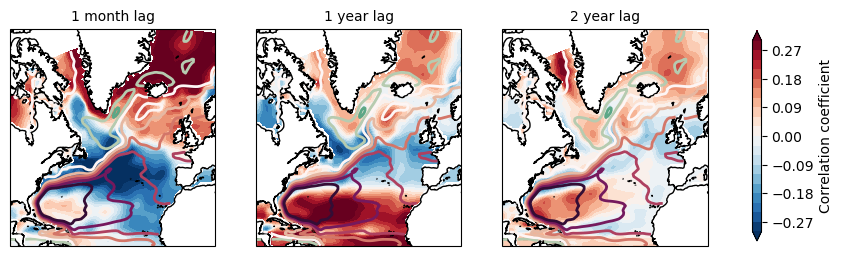

In [211]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

clev = np.linspace(-0.3, 0.3, 21)
p1 = axes[0].contourf(Ψ_NA.geolon_t, Ψ_NA.geolat_t, xr.corr(pcs_hgt_DJF.sel(mode = 0), Ψ_NA_1mtlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')
p2 = axes[1].contourf(Ψ_NA.geolon_t, Ψ_NA.geolat_t, xr.corr(pcs_hgt_DJF.sel(mode = 0), Ψ_NA_1yrlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')
p3 = axes[2].contourf(Ψ_NA.geolon_t, Ψ_NA.geolat_t, xr.corr(pcs_hgt_DJF.sel(mode = 0), Ψ_NA_2yrlag, 'time'), cmap = 'RdBu_r', levels = clev, transform = ccrs.PlateCarree(), extend = 'both')

for i in range(3):
    axes[i].contour(Ψ_NA.geolon_t, Ψ_NA.geolat_t, Ψ_NA.mean('time')/(ρ0 * m3_to_Sv), cmap = cm.cm.curl, levels = np.linspace(-30, 30, 11), transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Correlation coefficient', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    
axes[0].set_title('1 month lag', fontsize = 10)
axes[1].set_title('1 year lag', fontsize = 10)
axes[2].set_title('2 year lag', fontsize = 10)